<center><h1  style="color:white; background-color:#000000; border-radius: 0px; padding:25px;"> pySIRUS </h1></center>

Notebbok de test de pysirus avec une RF.


In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import time

import numpy as np

from sklearn.tree import _tree, export_text,plot_tree
from pysirus.models.basic import Node,SirusDTreeClassifier

In [2]:
print(os.getcwd())

/home/abdoulaye_sakho/S3/sirus/rules/notebook


In [3]:
os.path.join(os.getcwd(), os.pardir)

'/home/abdoulaye_sakho/S3/sirus/rules/notebook/..'

In [4]:
os.pardir

'..'

In [5]:
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [6]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
X_train.shape

(112, 4)

In [8]:
np.quantile(X,q=0.1,axis=0) # puis np.clip avec la liste des quantiles. 
#On replace les valeurs de chaque features par ça avec le clip. la RF est ensuite apprise sur ça

array([4.8, 2.5, 1.4, 0.2])

In [9]:
quantile =0.1
print(int(100//(quantile*100)))
list_quantile = [np.quantile(X_train,q=i*quantile,axis=0) for i in range(int(100//(quantile*100))+1)]
list_quantile

10


[array([4.3, 2. , 1.1, 0.1]),
 array([4.81, 2.5 , 1.4 , 0.2 ]),
 array([5.02, 2.7 , 1.5 , 0.2 ]),
 array([5.33, 2.9 , 1.63, 0.4 ]),
 array([5.6 , 3.  , 3.9 , 1.14]),
 array([5.8 , 3.  , 4.25, 1.3 ]),
 array([6.16, 3.1 , 4.7 , 1.5 ]),
 array([6.4, 3.2, 5.1, 1.8]),
 array([6.7 , 3.4 , 5.48, 2.  ]),
 array([6.99, 3.6 , 5.8 , 2.29]),
 array([7.9, 4.4, 6.9, 2.5])]

In [10]:
array_quantile = np.array(list_quantile )
array_quantile

array([[4.3 , 2.  , 1.1 , 0.1 ],
       [4.81, 2.5 , 1.4 , 0.2 ],
       [5.02, 2.7 , 1.5 , 0.2 ],
       [5.33, 2.9 , 1.63, 0.4 ],
       [5.6 , 3.  , 3.9 , 1.14],
       [5.8 , 3.  , 4.25, 1.3 ],
       [6.16, 3.1 , 4.7 , 1.5 ],
       [6.4 , 3.2 , 5.1 , 1.8 ],
       [6.7 , 3.4 , 5.48, 2.  ],
       [6.99, 3.6 , 5.8 , 2.29],
       [7.9 , 4.4 , 6.9 , 2.5 ]])

In [11]:
X_train_2 = X_train.copy()
#X_train_2[:,0] = array_quantile[out,0]
#X_train_2[:,0]

In [12]:
for dim in range(X_train.shape[1]):
    out = np.searchsorted(array_quantile[:,dim], X_train[:,dim],side='left')
    X_train_2[:,dim] = array_quantile[out,dim]

In [13]:
X_train_2

array([[6.16, 3.  , 4.25, 1.5 ],
       [5.8 , 2.7 , 4.25, 1.3 ],
       [6.99, 3.  , 5.8 , 2.29],
       [4.81, 3.2 , 1.4 , 0.2 ],
       [6.99, 3.1 , 5.1 , 2.5 ],
       [5.02, 3.6 , 1.63, 1.14],
       [5.6 , 4.4 , 1.5 , 0.2 ],
       [5.02, 2.  , 3.9 , 1.14],
       [6.7 , 3.  , 5.8 , 1.8 ],
       [6.7 , 3.4 , 5.8 , 2.5 ],
       [6.16, 2.5 , 5.1 , 1.5 ],
       [6.7 , 2.5 , 5.8 , 1.8 ],
       [5.6 , 2.5 , 3.9 , 1.14],
       [7.9 , 3.  , 6.9 , 2.5 ],
       [6.4 , 3.4 , 4.7 , 1.8 ],
       [5.6 , 2.5 , 3.9 , 1.14],
       [6.4 , 2.7 , 5.1 , 1.8 ],
       [6.4 , 2.9 , 5.1 , 1.5 ],
       [5.02, 2.5 , 4.7 , 1.8 ],
       [6.4 , 2.5 , 5.1 , 2.  ],
       [7.9 , 3.2 , 4.7 , 1.5 ],
       [6.7 , 3.  , 5.48, 2.  ],
       [6.16, 3.4 , 4.7 , 1.8 ],
       [4.81, 3.1 , 1.63, 0.2 ],
       [5.8 , 2.7 , 5.1 , 2.  ],
       [5.6 , 2.7 , 4.25, 1.3 ],
       [5.6 , 2.9 , 3.9 , 1.3 ],
       [5.6 , 2.5 , 4.25, 1.3 ],
       [6.16, 3.  , 4.7 , 1.5 ],
       [7.9 , 3.2 , 6.9 , 1.8 ],
       [5.

In [14]:
X_train

array([[5.9, 3. , 4.2, 1.5],
       [5.8, 2.6, 4. , 1.2],
       [6.8, 3. , 5.5, 2.1],
       [4.7, 3.2, 1.3, 0.2],
       [6.9, 3.1, 5.1, 2.3],
       [5. , 3.5, 1.6, 0.6],
       [5.4, 3.7, 1.5, 0.2],
       [5. , 2. , 3.5, 1. ],
       [6.5, 3. , 5.5, 1.8],
       [6.7, 3.3, 5.7, 2.5],
       [6. , 2.2, 5. , 1.5],
       [6.7, 2.5, 5.8, 1.8],
       [5.6, 2.5, 3.9, 1.1],
       [7.7, 3. , 6.1, 2.3],
       [6.3, 3.3, 4.7, 1.6],
       [5.5, 2.4, 3.8, 1.1],
       [6.3, 2.7, 4.9, 1.8],
       [6.3, 2.8, 5.1, 1.5],
       [4.9, 2.5, 4.5, 1.7],
       [6.3, 2.5, 5. , 1.9],
       [7. , 3.2, 4.7, 1.4],
       [6.5, 3. , 5.2, 2. ],
       [6. , 3.4, 4.5, 1.6],
       [4.8, 3.1, 1.6, 0.2],
       [5.8, 2.7, 5.1, 1.9],
       [5.6, 2.7, 4.2, 1.3],
       [5.6, 2.9, 3.6, 1.3],
       [5.5, 2.5, 4. , 1.3],
       [6.1, 3. , 4.6, 1.4],
       [7.2, 3.2, 6. , 1.8],
       [5.3, 3.7, 1.5, 0.2],
       [4.3, 3. , 1.1, 0.1],
       [6.4, 2.7, 5.3, 1.9],
       [5.7, 3. , 4.2, 1.2],
       [5.4, 3

In [15]:
X_train_original = X_train

In [16]:
X_train = X_train_2

In [17]:
X_train

array([[6.16, 3.  , 4.25, 1.5 ],
       [5.8 , 2.7 , 4.25, 1.3 ],
       [6.99, 3.  , 5.8 , 2.29],
       [4.81, 3.2 , 1.4 , 0.2 ],
       [6.99, 3.1 , 5.1 , 2.5 ],
       [5.02, 3.6 , 1.63, 1.14],
       [5.6 , 4.4 , 1.5 , 0.2 ],
       [5.02, 2.  , 3.9 , 1.14],
       [6.7 , 3.  , 5.8 , 1.8 ],
       [6.7 , 3.4 , 5.8 , 2.5 ],
       [6.16, 2.5 , 5.1 , 1.5 ],
       [6.7 , 2.5 , 5.8 , 1.8 ],
       [5.6 , 2.5 , 3.9 , 1.14],
       [7.9 , 3.  , 6.9 , 2.5 ],
       [6.4 , 3.4 , 4.7 , 1.8 ],
       [5.6 , 2.5 , 3.9 , 1.14],
       [6.4 , 2.7 , 5.1 , 1.8 ],
       [6.4 , 2.9 , 5.1 , 1.5 ],
       [5.02, 2.5 , 4.7 , 1.8 ],
       [6.4 , 2.5 , 5.1 , 2.  ],
       [7.9 , 3.2 , 4.7 , 1.5 ],
       [6.7 , 3.  , 5.48, 2.  ],
       [6.16, 3.4 , 4.7 , 1.8 ],
       [4.81, 3.1 , 1.63, 0.2 ],
       [5.8 , 2.7 , 5.1 , 2.  ],
       [5.6 , 2.7 , 4.25, 1.3 ],
       [5.6 , 2.9 , 3.9 , 1.3 ],
       [5.6 , 2.5 , 4.25, 1.3 ],
       [6.16, 3.  , 4.7 , 1.5 ],
       [7.9 , 3.2 , 6.9 , 1.8 ],
       [5.

In [18]:
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

[Text(0.5, 0.9444444444444444, 'x[3] <= 0.77\ngini = 0.665\nsamples = 112\nvalue = [37, 34, 41]'),
 Text(0.4, 0.8333333333333334, 'gini = 0.0\nsamples = 35\nvalue = [35, 0, 0]'),
 Text(0.45, 0.8888888888888888, 'True  '),
 Text(0.6, 0.8333333333333334, 'x[2] <= 4.9\ngini = 0.521\nsamples = 77\nvalue = [2, 34, 41]'),
 Text(0.55, 0.8888888888888888, '  False'),
 Text(0.4, 0.7222222222222222, 'x[0] <= 5.465\ngini = 0.169\nsamples = 33\nvalue = [2, 30, 1]'),
 Text(0.3, 0.6111111111111112, 'x[1] <= 2.95\ngini = 0.611\nsamples = 6\nvalue = [2, 3, 1]'),
 Text(0.2, 0.5, 'x[3] <= 1.47\ngini = 0.375\nsamples = 4\nvalue = [0, 3, 1]'),
 Text(0.1, 0.3888888888888889, 'gini = 0.0\nsamples = 3\nvalue = [0, 3, 0]'),
 Text(0.3, 0.3888888888888889, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.4, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]'),
 Text(0.5, 0.6111111111111112, 'gini = 0.0\nsamples = 27\nvalue = [0, 27, 0]'),
 Text(0.8, 0.7222222222222222, 'x[3] <= 1.9\ngini = 0.165\nsamples = 

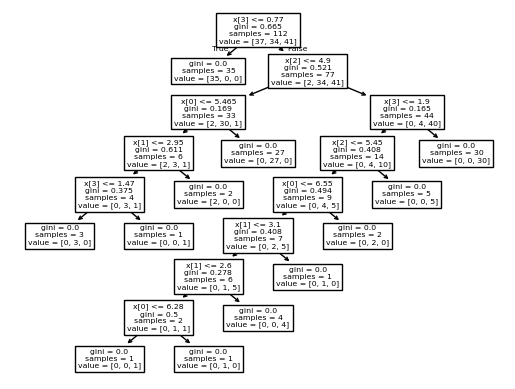

In [19]:
tree.plot_tree(clf)

## Essai .fit() :

In [20]:
rule = export_text(clf,feature_names=iris.feature_names,show_weights=True,max_depth=10)
rule

'|--- petal width (cm) <= 0.77\n|   |--- weights: [35.00, 0.00, 0.00] class: 0\n|--- petal width (cm) >  0.77\n|   |--- petal length (cm) <= 4.90\n|   |   |--- sepal length (cm) <= 5.46\n|   |   |   |--- sepal width (cm) <= 2.95\n|   |   |   |   |--- petal width (cm) <= 1.47\n|   |   |   |   |   |--- weights: [0.00, 3.00, 0.00] class: 1\n|   |   |   |   |--- petal width (cm) >  1.47\n|   |   |   |   |   |--- weights: [0.00, 0.00, 1.00] class: 2\n|   |   |   |--- sepal width (cm) >  2.95\n|   |   |   |   |--- weights: [2.00, 0.00, 0.00] class: 0\n|   |   |--- sepal length (cm) >  5.46\n|   |   |   |--- weights: [0.00, 27.00, 0.00] class: 1\n|   |--- petal length (cm) >  4.90\n|   |   |--- petal width (cm) <= 1.90\n|   |   |   |--- petal length (cm) <= 5.45\n|   |   |   |   |--- sepal length (cm) <= 6.55\n|   |   |   |   |   |--- sepal width (cm) <= 3.10\n|   |   |   |   |   |   |--- sepal width (cm) <= 2.60\n|   |   |   |   |   |   |   |--- sepal length (cm) <= 6.28\n|   |   |   |   |  

In [21]:
rule[1]

'-'

In [22]:
print(rule)

|--- petal width (cm) <= 0.77
|   |--- weights: [35.00, 0.00, 0.00] class: 0
|--- petal width (cm) >  0.77
|   |--- petal length (cm) <= 4.90
|   |   |--- sepal length (cm) <= 5.46
|   |   |   |--- sepal width (cm) <= 2.95
|   |   |   |   |--- petal width (cm) <= 1.47
|   |   |   |   |   |--- weights: [0.00, 3.00, 0.00] class: 1
|   |   |   |   |--- petal width (cm) >  1.47
|   |   |   |   |   |--- weights: [0.00, 0.00, 1.00] class: 2
|   |   |   |--- sepal width (cm) >  2.95
|   |   |   |   |--- weights: [2.00, 0.00, 0.00] class: 0
|   |   |--- sepal length (cm) >  5.46
|   |   |   |--- weights: [0.00, 27.00, 0.00] class: 1
|   |--- petal length (cm) >  4.90
|   |   |--- petal width (cm) <= 1.90
|   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |--- sepal length (cm) <= 6.55
|   |   |   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |   |   |--- sepal width (cm) <= 2.60
|   |   |   |   |   |   |   |--- sepal length (cm) <= 6.28
|   |   |   |   |   |   |   |   |--- weig

In [23]:
tree = clf.tree_
iterator = enumerate(zip(tree.children_left, tree.children_right, tree.feature, tree.threshold, tree.value))
for node_idx, data in iterator:
    left, right, feature, th, value = data

    # left: index of left child (if any)
    # right: index of right child (if any)
    # feature: index of the feature to check
    # th: the threshold to compare against
    # value: values associated with classes            

    # for classifier, value is 0 except the index of the class to return
    print(value)
    class_idx = np.argmax(value[0])

    if left == -1 and right == -1:
        print('{} LEAF: return class={}'.format(node_idx, class_idx))
    else:
        print('{} NODE: if feature[{}] < {} then next={} else next={}'.format(node_idx, feature, th, left, right)) 

[[0.33035714 0.30357143 0.36607143]]
0 NODE: if feature[3] < 0.7699999958276749 then next=1 else next=2
[[1. 0. 0.]]
1 LEAF: return class=0
[[0.02597403 0.44155844 0.53246753]]
2 NODE: if feature[2] < 4.8999998569488525 then next=3 else next=10
[[0.06060606 0.90909091 0.03030303]]
3 NODE: if feature[0] < 5.4649999141693115 then next=4 else next=9
[[0.33333333 0.5        0.16666667]]
4 NODE: if feature[1] < 2.950000047683716 then next=5 else next=8
[[0.   0.75 0.25]]
5 NODE: if feature[3] < 1.4699999690055847 then next=6 else next=7
[[0. 1. 0.]]
6 LEAF: return class=1
[[0. 0. 1.]]
7 LEAF: return class=2
[[1. 0. 0.]]
8 LEAF: return class=0
[[0. 1. 0.]]
9 LEAF: return class=1
[[0.         0.09090909 0.90909091]]
10 NODE: if feature[3] < 1.899999976158142 then next=11 else next=22
[[0.         0.28571429 0.71428571]]
11 NODE: if feature[2] < 5.450000047683716 then next=12 else next=21
[[0.         0.44444444 0.55555556]]
12 NODE: if feature[0] < 6.549999952316284 then next=13 else next=20


In [24]:
(5,2,'R') == (5,2,'R')

True

In [25]:
tree.children_left[0]

1

In [26]:
tree.max_depth

8

## Functions :

In [27]:
def explore_tree(tree,node_id,side):
    if tree.children_left[node_id] != _tree.TREE_LEAF: # possible to add a max_depth constraint exploration value
        id_left_child = tree.children_left[node_id]
        id_right_child = tree.children_right[node_id]
        #children = [
        #        (tree.feature[id_left_child],tree.threshold[id_left_child],'L'),
        #        (tree.feature[id_right_child],tree.threshold[id_right_child],'R'),
        #        ]
        children = [
            explore_tree(tree,id_left_child,'L'),
            explore_tree(tree,id_right_child,'R')
        ]
    else:
        return Node(feature=tree.feature[node_id],treshold=tree.threshold[node_id],side=side,node_id=node_id)
    
    return Node(tree.feature[node_id],tree.threshold[node_id],side,node_id,*children)

In [28]:
res = explore_tree(tree=tree,node_id=0,side='Root')


In [29]:
res.children

(<pysirus.models.basic.Node at 0x7dccc9b04ad0>,
 <pysirus.models.basic.Node at 0x7dccc9b05e90>)

In [30]:
res.children[0].feature



-2

In [31]:
tree_structure = [[]]
stack = [(res,0)]  # start with the root node id (0) and its depth (0)
depth = 0
while len(stack) > 0:
    curr_rule,indice_in_tree_struct = stack.pop()
    is_split_node = (curr_rule.feature != -2)

    if is_split_node:
        rule_left = (curr_rule.feature,curr_rule.treshold,'L')
        rule_right = (curr_rule.feature,curr_rule.treshold,'R')
        common_path_rules = tree_structure[indice_in_tree_struct].copy()
        common_path_rules.append(rule_right)
        tree_structure.append(common_path_rules) ## DROITE : Ajouté à la fin
        tree_structure[indice_in_tree_struct].append(rule_left) ## GAUCHE  : On le rajoute selon indice_in_tree_struct

        stack.append((curr_rule.children[0],indice_in_tree_struct))
        stack.append(( curr_rule.children[1],len(tree_structure)-1 ))
    else:
        #print('c')
        continue

In [32]:
tree_structure

[[(3, 0.7699999958276749, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L'),
  (3, 1.4699999690055847, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'R'),
  (3, 1.899999976158142, 'L'),
  (2, 5.450000047683716, 'L'),
  (0, 6.549999952316284, 'L'),
  (1, 3.100000023841858, 'L'),
  (1, 2.600000023841858, 'L'),
  (0, 6.2799999713897705, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'R'),
  (3, 1.899999976158142, 'R')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'R'),
  (3, 1.899999976158142, 'L'),
  (2, 5.450000047683716, 'R')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'R'),
  (3, 1.899999976158142, 'L'),
  (2, 5.450000047683716, 'L'),
  (0, 6.549999952316284, 'R')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'R'),
  (3, 1.899999976158142, 'L'),
  (2, 5.450000047683716, 'L'),
  (0, 6.549999952316284, 'L'),
  (1, 3.100000023

In [33]:
len(tree_structure)

12

In [34]:
all_paths_list = []
for i in range(len(tree_structure)):
    #print('*****'*10)
    #print(tree_structure[i])
    max_size_curr_path = len(tree_structure[i])
    #for k in range()
    for j in range(max_size_curr_path): ## fonction
        #print('####')
        #print('curr sous path :', tree_structure[i][:(max_size_curr_path-j)])
        all_paths_list.append(tree_structure[i][:(max_size_curr_path-j)])

In [35]:
all_paths_list

[[(3, 0.7699999958276749, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L'),
  (3, 1.4699999690055847, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L')],
 [(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'L')],
 [(3, 0.7699999958276749, 'R')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'R'),
  (3, 1.899999976158142, 'L'),
  (2, 5.450000047683716, 'L'),
  (0, 6.549999952316284, 'L'),
  (1, 3.100000023841858, 'L'),
  (1, 2.600000023841858, 'L'),
  (0, 6.2799999713897705, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'R'),
  (3, 1.899999976158142, 'L'),
  (2, 5.450000047683716, 'L'),
  (0, 6.549999952316284, 'L'),
  (1, 3.100000023841858, 'L'),
  (1, 2.600000023841858, 'L')],
 [(3, 0.769999

In [36]:
def split_sub_rules(path,is_removing_singleton=False):
    list_sub_path = []
    max_size_curr_path = len(path)
    if is_removing_singleton:
        int_to_add = 1
    else:
        int_to_add = 0
    for j in range(max_size_curr_path-int_to_add):
        list_sub_path.append(path[:(max_size_curr_path-j)])
    return list_sub_path


all_paths_list = []
for i in range(len(tree_structure)):
    print('*****'*10)
    curr_path = tree_structure[i]
    max_size_curr_path = len(curr_path)
    
    for k in range(max_size_curr_path):
        list_sub_path = split_sub_rules(curr_path[k:],is_removing_singleton=False)
        print('ici : ', list_sub_path)
        all_paths_list.extend(list_sub_path)

    ## CAS plus complexes :
    if max_size_curr_path ==1:
        #all_paths_list.append(curr_path)
        print("SKIIIIP")
        continue
    else:
        curr_path_size_pair = ( (max_size_curr_path%2)==0)
        print('TAIIIILLE : ',max_size_curr_path)

        if curr_path_size_pair:
            print('aa')
            #list_sub_path = split_sub_rules(curr_path)
            #all_paths_list.extend(list_sub_path)          
            for k in range(1, (max_size_curr_path//2) ):
                print('curr path : ',curr_path[k:max_size_curr_path-k])
                list_sub_path = split_sub_rules(curr_path[k:max_size_curr_path-k],is_removing_singleton=True)
                print('list_sub_path : ',list_sub_path)
                all_paths_list.extend(list_sub_path)
        else:
            print('b')
            #list_sub_path = split_sub_rules(curr_path)
            #all_paths_list.extend(list_sub_path)
            for k in range(1,(max_size_curr_path//2) ):
                print('curr path : ',curr_path[k:max_size_curr_path-k])
                list_sub_path = split_sub_rules(curr_path[k:max_size_curr_path-k],is_removing_singleton=True)
                all_paths_list.extend(list_sub_path)
                print('list_sub_path : ',list_sub_path)
                if k == (max_size_curr_path//2): #case odd last 
                    list_sub_path = split_sub_rules(curr_path[k:max_size_curr_path-(k-1)],is_removing_singleton=True)
                    print('list_sub_path : ',list_sub_path)
                    all_paths_list.extend(list_sub_path)
    print('end iteration all_paths_list : ',all_paths_list)
        

**************************************************
ici :  [[(3, 0.7699999958276749, 'L')]]
SKIIIIP
**************************************************
ici :  [[(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'L'), (0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'L'), (3, 1.4699999690055847, 'L')], [(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'L'), (0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'L')], [(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'L'), (0, 5.4649999141693115, 'L')], [(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'L')], [(3, 0.7699999958276749, 'R')]]
ici :  [[(2, 4.8999998569488525, 'L'), (0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'L'), (3, 1.4699999690055847, 'L')], [(2, 4.8999998569488525, 'L'), (0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'L')], [(2, 4.8999998569488525, 'L'), (0, 5.4649999141693115, 'L')], [(2, 4.8999998569488525, 'L')]]
ici :  [[(0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'L'), (3

In [37]:
len(tree_structure)

12

In [38]:
3 // 2

1

In [39]:
tree_structure[1]

[(3, 0.7699999958276749, 'R'),
 (2, 4.8999998569488525, 'L'),
 (0, 5.4649999141693115, 'L'),
 (1, 2.950000047683716, 'L'),
 (3, 1.4699999690055847, 'L')]

In [40]:
tree_structure[1][1:-1]

[(2, 4.8999998569488525, 'L'),
 (0, 5.4649999141693115, 'L'),
 (1, 2.950000047683716, 'L')]

In [41]:
all_paths_list

[[(3, 0.7699999958276749, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L'),
  (3, 1.4699999690055847, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L')],
 [(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'L')],
 [(3, 0.7699999958276749, 'R')],
 [(2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L'),
  (3, 1.4699999690055847, 'L')],
 [(2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L')],
 [(2, 4.8999998569488525, 'L'), (0, 5.4649999141693115, 'L')],
 [(2, 4.8999998569488525, 'L')],
 [(0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L'),
  (3, 1.4699999690055847, 'L')],
 [(0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'L')],
 [(0, 5.

In [42]:
len(all_paths_list)

235

In [43]:
print(len(tree_structure[0]),len(tree_structure[1]),len(tree_structure[2]),len(tree_structure[3]),len(tree_structure[4]),
     len(tree_structure[5]),len(tree_structure[6]))

1 5 8 3 4 5 6


In [44]:
import math

In [45]:
1 + (3*4)/2 + (4*5/2)+1 + 3*4/2 + (4*5/2)+1 + (4*5/2)+1 + (4*5/2)+1

57.0

In [46]:
1 + 6 + 11 + 6 + 11 + 11 + 11

57

In [47]:
all_paths_list_str = [str(elem) for elem in all_paths_list]

In [48]:
unique_str_rules,indices_rules,count_rules = np.unique(all_paths_list_str,return_counts=True,return_index=True)

In [49]:
unique_str_rules

array(["[(0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'L'), (3, 1.4699999690055847, 'L')]",
       "[(0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'L'), (3, 1.4699999690055847, 'R')]",
       "[(0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'L')]",
       "[(0, 5.4649999141693115, 'L'), (1, 2.950000047683716, 'R')]",
       "[(0, 5.4649999141693115, 'L')]", "[(0, 5.4649999141693115, 'R')]",
       "[(0, 6.2799999713897705, 'L')]", "[(0, 6.2799999713897705, 'R')]",
       "[(0, 6.549999952316284, 'L'), (1, 3.100000023841858, 'L'), (1, 2.600000023841858, 'L'), (0, 6.2799999713897705, 'L')]",
       "[(0, 6.549999952316284, 'L'), (1, 3.100000023841858, 'L'), (1, 2.600000023841858, 'L'), (0, 6.2799999713897705, 'R')]",
       "[(0, 6.549999952316284, 'L'), (1, 3.100000023841858, 'L'), (1, 2.600000023841858, 'L')]",
       "[(0, 6.549999952316284, 'L'), (1, 3.100000023841858, 'L'), (1, 2.600000023841858, 'R')]",
       "[(0, 6.549999952316284, 'L'), (1, 3.10000002384185

In [50]:
len(unique_str_rules)

96

In [51]:
count_rules

array([ 1,  1,  2,  1,  3,  1,  1,  1,  1,  1,  2,  1,  3,  1,  4,  1,  1,
        1,  2,  1,  1,  1,  2,  1,  1,  1,  2,  1,  3,  1,  1,  1,  4,  1,
        6,  1,  4,  1,  1,  4,  1,  6,  1,  8,  1, 10,  1, 12,  1,  7,  1,
        1,  2,  1,  3,  1,  6,  1,  5,  1,  1,  1,  1,  2,  1,  3,  1,  4,
        1,  1,  2,  1,  3,  1,  4,  1,  5,  1,  6,  1,  7, 11,  1,  1,  1,
        1,  2,  1,  5,  1,  7,  1,  9,  1,  6,  1])

In [52]:
-np.sort(-(count_rules / len(count_rules))) > 0.09

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [53]:
(-np.sort(-(count_rules / len(count_rules))) > 0.09).sum()

4

In [54]:
len(count_rules)

96

In [55]:
count_rules[23]

1

In [56]:
indices_rules

array([ 10, 227,  11, 214,  12, 206,  53, 191,  44, 182,  45, 144,  46,
       115,  47,  94,  51, 189,  52, 149,  13, 230,  14, 216,  48, 186,
        49, 147,  50, 117,   6, 223,   7, 211,   8, 204,   9,  26, 164,
        27, 129,  28, 103,  29,  85,  30,  73,  31,  66,  32,  39, 177,
        40, 140,  41, 112,  42,  92,  43,  78,   0,   1, 218,   2, 207,
         3, 201,   4,  18, 156,  19, 122,  20,  97,  21,  80,  22,  69,
        23,  63,  24,   5,  15, 232,  33, 171,  34, 135,  35, 108,  36,
        89,  37,  76,  38,  68])

In [57]:
np.sort(-count_rules)

array([-12, -11, -10,  -9,  -8,  -7,  -7,  -7,  -6,  -6,  -6,  -6,  -6,
        -5,  -5,  -5,  -4,  -4,  -4,  -4,  -4,  -4,  -3,  -3,  -3,  -3,
        -3,  -3,  -2,  -2,  -2,  -2,  -2,  -2,  -2,  -2,  -2,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1])

In [58]:
count_sort_ind = np.argsort(-count_rules)
count_sort_ind

array([47, 81, 45, 92, 43, 49, 90, 80, 94, 41, 34, 56, 78, 76, 58, 88, 36,
       67, 39, 14, 32, 74, 54,  4, 65, 72, 28, 12, 70, 26,  2, 63, 22, 18,
       86, 10, 52, 64, 61, 62, 93, 60, 83, 59, 75, 66, 91, 89, 85, 68, 69,
       79, 71, 77, 73, 87, 82, 84,  0, 55, 21, 20, 19, 17, 16, 15, 13, 11,
        9,  8,  7,  6,  5,  3,  1, 23, 57, 24, 27, 53, 51, 50, 48, 46, 44,
       42, 40, 38, 37, 35, 33, 31, 30, 29, 25, 95])

In [59]:
count_sort_ind[:10]

array([47, 81, 45, 92, 43, 49, 90, 80, 94, 41])

In [60]:
count_sort_ind[:1]

array([47])

In [61]:
all_paths_list[47]

[(0, 6.549999952316284, 'L')]

In [62]:
all_paths_list[81]

[(3, 0.7699999958276749, 'R'),
 (2, 4.8999998569488525, 'R'),
 (3, 1.899999976158142, 'L'),
 (2, 5.450000047683716, 'L')]

selected_rules_indices = count_sort_ind[:10]
selected_rules = [all_paths_list[i] for i in selected_rules_indices] ## pas utile ici. Le faire en bas.
selected_rules

In [63]:
def from_rules_to_constraint(rule):
    dimension = rule[0]
    treshold = rule[1]
    sign = rule[2]
    return dimension,treshold,sign

In [64]:
dimension,treshold,sign = from_rules_to_constraint(rule=all_paths_list[47][0])
dimension,treshold,sign

(0, 6.549999952316284, 'L')

In [65]:
(X_train[:,dimension]<=treshold)

array([ True,  True, False,  True, False,  True,  True,  True, False,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False, False, False,  True,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True, False, False,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True])

In [66]:
(X_train[:,dimension]<=treshold) & (X_train[:,dimension]<=treshold-1)

array([False, False, False,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False,  True, False,  True,  True, False, False, False,  True,
       False, False, False, False,  True,  True, False, False,  True,
       False,  True, False, False,  True,  True, False,  True,  True,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True, False, False, False,  True, False, False,  True,
       False, False, False,  True,  True, False,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False,  True,  True,
       False, False, False,  True])

In [67]:
((X_train[:,dimension]<=treshold) & (X_train[:,dimension]<=treshold-1)).shape

(112,)

In [68]:
X_train.shape

(112, 4)

In [69]:
X_train[(X_train[:,dimension]<=treshold) & (X_train[:,dimension]<=treshold-1)]

array([[4.81, 3.2 , 1.4 , 0.2 ],
       [5.02, 3.6 , 1.63, 1.14],
       [5.02, 2.  , 3.9 , 1.14],
       [5.02, 2.5 , 4.7 , 1.8 ],
       [4.81, 3.1 , 1.63, 0.2 ],
       [5.33, 4.4 , 1.5 , 0.2 ],
       [4.3 , 3.  , 1.1 , 0.1 ],
       [4.81, 3.1 , 1.5 , 0.2 ],
       [5.33, 2.5 , 3.9 , 1.14],
       [4.81, 3.4 , 1.4 , 0.4 ],
       [4.81, 3.  , 1.4 , 0.1 ],
       [5.33, 4.4 , 1.63, 0.2 ],
       [4.81, 3.4 , 1.63, 0.2 ],
       [4.81, 2.5 , 1.4 , 0.4 ],
       [5.02, 3.  , 1.4 , 0.2 ],
       [4.81, 3.2 , 1.4 , 0.2 ],
       [5.02, 3.6 , 1.4 , 0.2 ],
       [5.33, 3.6 , 1.4 , 0.4 ],
       [4.81, 3.  , 1.4 , 0.2 ],
       [5.33, 3.6 , 1.4 , 0.2 ],
       [5.02, 3.1 , 1.5 , 0.2 ],
       [5.33, 3.4 , 1.4 , 0.2 ],
       [5.02, 3.2 , 1.4 , 0.2 ],
       [5.33, 3.4 , 3.9 , 1.14],
       [5.02, 2.5 , 3.9 , 1.14],
       [5.33, 4.4 , 1.5 , 0.1 ],
       [5.33, 4.4 , 1.5 , 0.4 ],
       [4.81, 3.2 , 1.63, 0.2 ],
       [5.02, 3.4 , 1.4 , 0.2 ],
       [5.02, 3.  , 1.63, 0.2 ],
       [5.

In [70]:
def generate_single_rule_mask(X,dimension,treshold,sign):
    if sign=='L':
        return (X[:,dimension]<=treshold) #.mean()
    else:
        return (X[:,dimension]>treshold)#.mean()


In [71]:
from operator import and_
from functools import reduce
from collections import Counter
list_mask_by_rules = []
for indice in count_sort_ind[:10]:#for loop for getting all the values in train passing the rules
    current_rules = all_paths_list[indice]
    list_mask=[]
    for j in range(len(current_rules)):
        print(current_rules)
        print(current_rules[j])
        dimension,treshold,sign = from_rules_to_constraint(rule=current_rules[j])
        mask = generate_single_rule_mask(X=X_train,dimension=dimension,treshold=treshold,sign=sign)
        list_mask.append(mask)
    final_mask = reduce(and_, list_mask)
    list_mask_by_rules.append(final_mask)
    print("########")
    #print((y_train[final_mask]).sum() / len(y_train[final_mask])) #binary case
    n_classe=3
    y_train_rule = y_train[final_mask]
    print(y_train_rule)
    for cl in range(n_classe):# nb de classe
        print('Class ',cl,' : ',len(y_train_rule[y_train_rule==cl]) / len(y_train_rule)) #binary case
    print(Counter(y_train_rule))
    print(Counter(y_train_rule).most_common(1)[0][0])
    

[(0, 6.549999952316284, 'L')]
(0, 6.549999952316284, 'L')
########
[1 1 0 0 0 1 2 1 1 1 2 2 2 2 1 0 2 1 1 1 1 0 0 2 1 0 0 0 2 1 0 1 1 0 2 0 0
 0 2 0 2 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 2 0 0 0 0 2 1 1 1 2 1 0 1 2 0 1 1
 1 0 0 0 2 1 0]
Class  0  :  0.4567901234567901
Class  1  :  0.345679012345679
Class  2  :  0.19753086419753085
Counter({0: 37, 1: 28, 2: 16})
0
[(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'R'), (3, 1.899999976158142, 'L'), (2, 5.450000047683716, 'L')]
(3, 0.7699999958276749, 'R')
[(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'R'), (3, 1.899999976158142, 'L'), (2, 5.450000047683716, 'L')]
(2, 4.8999998569488525, 'R')
[(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'R'), (3, 1.899999976158142, 'L'), (2, 5.450000047683716, 'L')]
(3, 1.899999976158142, 'L')
[(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'R'), (3, 1.899999976158142, 'L'), (2, 5.450000047683716, 'L')]
(2, 5.450000047683716, 'L')
########
[2 2 2 1 2 2 1 1 1]
Class  0  :  0.0
Cl

In [72]:
np.unique(y_train)

array([0, 1, 2])

In [73]:
np.mean(list_mask_by_rules,axis=1)

array([0.72321429, 0.08035714, 0.14285714, 0.07142857, 0.74107143,
       0.15178571, 0.6875    , 0.01785714, 0.27678571, 0.40178571])

In [74]:
np.mean(list_mask_by_rules,axis=1).argmax()

4

In [75]:
np.mean(list_mask_by_rules,axis=1)

array([0.72321429, 0.08035714, 0.14285714, 0.07142857, 0.74107143,
       0.15178571, 0.6875    , 0.01785714, 0.27678571, 0.40178571])

In [76]:
y_train.dtype

dtype('int64')

In [77]:
y_train.dtype == int

True

In [78]:
all_paths_list[:10]

[[(3, 0.7699999958276749, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L'),
  (3, 1.4699999690055847, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L')],
 [(3, 0.7699999958276749, 'R'),
  (2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L')],
 [(3, 0.7699999958276749, 'R'), (2, 4.8999998569488525, 'L')],
 [(3, 0.7699999958276749, 'R')],
 [(2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L'),
  (3, 1.4699999690055847, 'L')],
 [(2, 4.8999998569488525, 'L'),
  (0, 5.4649999141693115, 'L'),
  (1, 2.950000047683716, 'L')],
 [(2, 4.8999998569488525, 'L'), (0, 5.4649999141693115, 'L')],
 [(2, 4.8999998569488525, 'L')]]

In [79]:
def get_probas_rules(X,rules):
    list_mask=[]
    for j in range(len(rules)):
        dimension,treshold,sign = from_rules_to_constraint(rule=rules[j])
        mask = generate_single_rule_mask(X=X,dimension=dimension,treshold=treshold,sign=sign)
        list_mask.append(mask)
    final_mask = reduce(and_, list_mask)
    return final_mask
    

In [80]:
aa = [2,3,4]
bb = [4,6,8]

In [81]:
cc = np.array([np.random.uniform(low=aa[i],high=bb[i],size=(10)) for i in range(len(aa))]).T
cc

array([[2.05603781, 5.02211465, 6.64413613],
       [3.20078371, 4.37920543, 5.94292427],
       [2.00048541, 3.81385856, 4.93305933],
       [3.87318262, 3.95960307, 7.97934914],
       [3.76750263, 4.97093143, 5.1437955 ],
       [2.72317455, 3.68132902, 7.47348285],
       [3.30941474, 3.9822219 , 6.97559924],
       [3.63523803, 5.41443064, 6.95097797],
       [3.01998696, 3.35081236, 7.23042488],
       [2.84116455, 4.10404158, 4.61985028]])

In [82]:
cc.T

array([[2.05603781, 3.20078371, 2.00048541, 3.87318262, 3.76750263,
        2.72317455, 3.30941474, 3.63523803, 3.01998696, 2.84116455],
       [5.02211465, 4.37920543, 3.81385856, 3.95960307, 4.97093143,
        3.68132902, 3.9822219 , 5.41443064, 3.35081236, 4.10404158],
       [6.64413613, 5.94292427, 4.93305933, 7.97934914, 5.1437955 ,
        7.47348285, 6.97559924, 6.95097797, 7.23042488, 4.61985028]])

In [83]:
cc .shape

(10, 3)

In [84]:
probas = np.zeros(len(all_paths_list[:10]))
for i,rules in enumerate(all_paths_list[:10]):
    mask = get_probas_rules(X=X_train,rules=rules)
    X_train_valid = X_train[mask]
    probas[i] = len(X_train_valid) / len(X_train)
probas    

array([0.3125    , 0.02678571, 0.03571429, 0.05357143, 0.29464286,
       0.6875    , 0.03571429, 0.04464286, 0.30357143, 0.60714286])

In [85]:
all_paths_list[0]

[(3, 0.7699999958276749, 'L')]

In [86]:
all_paths_list[1]

[(3, 0.7699999958276749, 'R'),
 (2, 4.8999998569488525, 'L'),
 (0, 5.4649999141693115, 'L'),
 (1, 2.950000047683716, 'L'),
 (3, 1.4699999690055847, 'L')]

In [87]:
aa= [1,2,3,4,5,6]
aa[3:8]

[4, 5, 6]

In [88]:
all_paths_list[0]+all_paths_list[1]

[(3, 0.7699999958276749, 'L'),
 (3, 0.7699999958276749, 'R'),
 (2, 4.8999998569488525, 'L'),
 (0, 5.4649999141693115, 'L'),
 (1, 2.950000047683716, 'L'),
 (3, 1.4699999690055847, 'L')]

In [89]:
if not False:
    print('a')

a


## Class : 

### Dtree :

In [90]:
from sklearn.metrics import average_precision_score, accuracy_score,roc_auc_score

In [91]:
from pysirus.models._QuantileSplitter import QuantileBestSplitter

In [92]:
X_train_original

array([[5.9, 3. , 4.2, 1.5],
       [5.8, 2.6, 4. , 1.2],
       [6.8, 3. , 5.5, 2.1],
       [4.7, 3.2, 1.3, 0.2],
       [6.9, 3.1, 5.1, 2.3],
       [5. , 3.5, 1.6, 0.6],
       [5.4, 3.7, 1.5, 0.2],
       [5. , 2. , 3.5, 1. ],
       [6.5, 3. , 5.5, 1.8],
       [6.7, 3.3, 5.7, 2.5],
       [6. , 2.2, 5. , 1.5],
       [6.7, 2.5, 5.8, 1.8],
       [5.6, 2.5, 3.9, 1.1],
       [7.7, 3. , 6.1, 2.3],
       [6.3, 3.3, 4.7, 1.6],
       [5.5, 2.4, 3.8, 1.1],
       [6.3, 2.7, 4.9, 1.8],
       [6.3, 2.8, 5.1, 1.5],
       [4.9, 2.5, 4.5, 1.7],
       [6.3, 2.5, 5. , 1.9],
       [7. , 3.2, 4.7, 1.4],
       [6.5, 3. , 5.2, 2. ],
       [6. , 3.4, 4.5, 1.6],
       [4.8, 3.1, 1.6, 0.2],
       [5.8, 2.7, 5.1, 1.9],
       [5.6, 2.7, 4.2, 1.3],
       [5.6, 2.9, 3.6, 1.3],
       [5.5, 2.5, 4. , 1.3],
       [6.1, 3. , 4.6, 1.4],
       [7.2, 3.2, 6. , 1.8],
       [5.3, 3.7, 1.5, 0.2],
       [4.3, 3. , 1.1, 0.1],
       [6.4, 2.7, 5.3, 1.9],
       [5.7, 3. , 4.2, 1.2],
       [5.4, 3

In [93]:
clf_dtree = DecisionTreeClassifier(max_depth=10, random_state=0)
clf_dtree.fit(X_train_original, y_train)
y_pred_dtree = clf_dtree.predict(X_test)
y_pred_proba_dtree = clf_dtree.predict_proba(X_test)
print('PR AUC :', average_precision_score(y_test, y_pred_proba_dtree))
print('ROC AUC :', roc_auc_score(y_test, y_pred_proba_dtree,average='micro',multi_class='ovr'))
print('Accuracy :', accuracy_score(y_test, y_pred_dtree))

PR AUC : 0.9546052631578946
ROC AUC : 0.980263157894737
Accuracy : 0.9736842105263158


In [94]:
STree = SirusDTreeClassifier(max_depth=10, random_state=0)
#unique_str_rules_test,indices_rules_test,count_rules_test = STree.fit(X_train_original,y_train)
STree.fit(X_train_original,y_train,quantile=10)

array_quantile :  [[4.3  2.   1.1  0.1 ]
 [4.81 2.5  1.4  0.2 ]
 [5.02 2.7  1.5  0.2 ]
 [5.33 2.9  1.63 0.4 ]
 [5.6  3.   3.9  1.14]
 [5.8  3.   4.25 1.3 ]
 [6.16 3.1  4.7  1.5 ]
 [6.4  3.2  5.1  1.8 ]
 [6.7  3.4  5.48 2.  ]
 [6.99 3.6  5.8  2.29]
 [7.9  4.4  6.9  2.5 ]]
n_rules before post-treatment :  96
len(rules_to_keep) :  96
np.sum(rules_to_keep) :  96
rules_to_keep :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
self.n_rules :  96


SirusDTreeClassifier(max_depth=10, random_state=0)

In [95]:
STree.print_rules(max_rules=10)

########
Rules 0 
       &( X[:,0] <= 6.549999952316284 )
########
Rules 1 
       &( X[:,3] > 0.7699999958276749 )
       &( X[:,2] > 4.8999998569488525 )
       &( X[:,3] <= 1.899999976158142 )
       &( X[:,2] <= 5.450000047683716 )
########
Rules 2 
       &( X[:,0] <= 6.549999952316284 )
       &( X[:,1] <= 3.100000023841858 )
       &( X[:,1] <= 2.600000023841858 )
########
Rules 3 
       &( X[:,2] <= 5.450000047683716 )
       &( X[:,0] > 6.549999952316284 )
########
Rules 4 
       &( X[:,2] <= 5.450000047683716 )
########
Rules 5 
       &( X[:,1] <= 3.100000023841858 )
       &( X[:,1] <= 2.600000023841858 )
########
Rules 6 
       &( X[:,3] <= 1.899999976158142 )
       &( X[:,2] <= 5.450000047683716 )
########
Rules 7 
       &( X[:,3] > 0.7699999958276749 )
       &( X[:,2] > 4.8999998569488525 )
       &( X[:,3] <= 1.899999976158142 )
       &( X[:,2] <= 5.450000047683716 )
       &( X[:,0] > 6.549999952316284 )
########
Rules 8 
       &( X[:,0] > 6.549999952316284 )
#

In [96]:
y_pred_sirus = STree.predict(X_test)
y_pred_proba_sirus = STree.predict_proba(X_test)
print('PR AUC :', average_precision_score(y_test, y_pred_proba_sirus))
print('ROC AUC :', roc_auc_score(y_test, y_pred_proba_sirus,average='micro',multi_class='ovr'))
print('Accuracy :', accuracy_score(y_test, y_pred_sirus))

PR AUC : 0.9648959537950551
ROC AUC : 0.9549861495844876
Accuracy : 0.868421052631579


In [97]:
STree = SirusDTreeClassifier(max_depth=10, random_state=0,splitter="quantile")
#unique_str_rules_test,indices_rules_test,count_rules_test = STree.fit(X_train_original,y_train)
STree.fit(X_train_original,y_train,quantile=10)
y_pred_sirus = STree.predict(X_test)
y_pred_proba_sirus = STree.predict_proba(X_test)
print('PR AUC :', average_precision_score(y_test, y_pred_proba_sirus))
print('ROC AUC :', roc_auc_score(y_test, y_pred_proba_sirus,average='micro',multi_class='ovr'))
print('Accuracy :', accuracy_score(y_test, y_pred_sirus))

array_quantile :  [[4.3  2.   1.1  0.1 ]
 [4.81 2.5  1.4  0.2 ]
 [5.02 2.7  1.5  0.2 ]
 [5.33 2.9  1.63 0.4 ]
 [5.6  3.   3.9  1.14]
 [5.8  3.   4.25 1.3 ]
 [6.16 3.1  4.7  1.5 ]
 [6.4  3.2  5.1  1.8 ]
 [6.7  3.4  5.48 2.  ]
 [6.99 3.6  5.8  2.29]
 [7.9  4.4  6.9  2.5 ]]
n_rules before post-treatment :  94
len(rules_to_keep) :  94
np.sum(rules_to_keep) :  94
rules_to_keep :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
self.n_rules :  94
PR AUC : 0.9769901394901396
ROC AUC : 0.9536011080332409
Accuracy : 0.868421052631579


In [98]:
STree.print_rules(max_rules=10)

########
Rules 0 
       &( X[:,0] <= 6.400000095367432 )
       &( X[:,1] <= 3.0 )
       &( X[:,1] <= 2.5 )
########
Rules 1 
       &( X[:,2] > 4.699999809265137 )
       &( X[:,3] <= 1.7999999523162842 )
########
Rules 2 
       &( X[:,2] <= 5.099999904632568 )
########
Rules 3 
       &( X[:,3] <= 1.7999999523162842 )
       &( X[:,2] <= 5.099999904632568 )
########
Rules 4 
       &( X[:,2] <= 5.099999904632568 )
       &( X[:,0] <= 6.400000095367432 )
       &( X[:,1] <= 3.0 )
########
Rules 5 
       &( X[:,0] <= 6.400000095367432 )
########
Rules 6 
       &( X[:,2] > 5.099999904632568 )
########
Rules 7 
       &( X[:,2] > 4.699999809265137 )
########
Rules 8 
       &( X[:,2] > 4.699999809265137 )
       &( X[:,3] <= 1.7999999523162842 )
       &( X[:,2] <= 5.099999904632568 )
       &( X[:,0] <= 6.400000095367432 )
       &( X[:,1] <= 3.0 )
       &( X[:,1] <= 2.5 )
########
Rules 9 
       &( X[:,2] <= 5.099999904632568 )
       &( X[:,0] > 6.400000095367432 )


In [99]:
from sklearn.tree._splitter import Splitter

In [100]:
from sklearn.tree._criterion import Criterion


In [101]:
splitter = Splitter(Criterion('gini'),2,3,4,5,None)

In [102]:
isinstance(splitter, Splitter)

True

In [103]:
splitterAbd = QuantileBestSplitter(Criterion('gini'),2,3,4,5,None)

In [104]:
isinstance(splitterAbd, Splitter)

True

### Ensemble : 

In [105]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [106]:
from pysirus.models.basic import SirusRFClassifier,SirusGBClassifier

In [107]:
clf_rf = RandomForestClassifier(max_depth=10, random_state=0)
clf_rf.fit(X_train_original, y_train)
y_pred_dtree = clf_rf.predict(X_test)
y_pred_proba_dtree = clf_rf.predict_proba(X_test)
print('PR AUC :', average_precision_score(y_test, y_pred_proba_dtree))
print('ROC AUC :', roc_auc_score(y_test, y_pred_proba_dtree,average='micro',multi_class='ovr'))
print('Accuracy :', accuracy_score(y_test, y_pred_dtree))

PR AUC : 0.9780937683715462
ROC AUC : 0.996191135734072
Accuracy : 0.9736842105263158


In [108]:
clf_gb = GradientBoostingClassifier(random_state=0)
clf_gb.fit(X_train_original, y_train)
y_pred_dtree = clf_gb.predict(X_test)
y_pred_proba_dtree = clf_gb.predict_proba(X_test)
print('PR AUC :', average_precision_score(y_test, y_pred_proba_dtree))
print('ROC AUC :', roc_auc_score(y_test, y_pred_proba_dtree,average='micro',multi_class='ovr'))
print('Accuracy :', accuracy_score(y_test, y_pred_dtree))

PR AUC : 0.9780937683715463
ROC AUC : 0.9920360110803325
Accuracy : 0.9736842105263158


In [122]:
RFSirus = SirusRFClassifier(max_depth=10, random_state=0,splitter="quantile")
start = time.time()
RFSirus.fit(X_train_original,y_train,quantile=10,batch_size_post_treatment=50,p0=0.01)
end = time.time()
y_pred_sirus = RFSirus.predict(X_test)
y_pred_proba_sirus = RFSirus.predict_proba(X_test)
print('PR AUC :', average_precision_score(y_test, y_pred_proba_sirus))
print('ROC AUC :', roc_auc_score(y_test, y_pred_proba_sirus,average='micro',multi_class='ovr'))
print('Accuracy :', accuracy_score(y_test, y_pred_sirus))
time_2 = end-start
print('Fitting time = ',time_2 ,'s')

array_quantile :  [[4.3  2.   1.1  0.1 ]
 [4.81 2.5  1.4  0.2 ]
 [5.02 2.7  1.5  0.2 ]
 [5.33 2.9  1.63 0.4 ]
 [5.6  3.   3.9  1.14]
 [5.8  3.   4.25 1.3 ]
 [6.16 3.1  4.7  1.5 ]
 [6.4  3.2  5.1  1.8 ]
 [6.7  3.4  5.48 2.  ]
 [6.99 3.6  5.8  2.29]
 [7.9  4.4  6.9  2.5 ]]
n_rules before post-treatment :  53
len(rules_to_keep) :  53
np.sum(rules_to_keep) :  53
rules_to_keep :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
self.n_rules :  53
PR AUC : 0.9826058201058201
ROC AUC : 0.9657202216066482
Accuracy : 0.868421052631579
Fitting time =  0.5395498275756836 s


In [123]:
RFSirus.n_rules

53

In [124]:
RFSirus.print_rules(max_rules=10)

########
Rules 0 
       &( X[:,2] > 4.699999809265137 )
       &( X[:,2] <= 5.099999904632568 )
########
Rules 1 
       &( X[:,3] > 0.4000000059604645 )
       &( X[:,2] <= 4.699999809265137 )
       &( X[:,2] > 1.6299999952316284 )
       &( X[:,0] <= 5.329999923706055 )
       &( X[:,3] > 1.1399999856948853 )
########
Rules 2 
       &( X[:,3] <= 1.7999999523162842 )
       &( X[:,1] <= 2.9000000953674316 )
########
Rules 3 
       &( X[:,2] > 1.6299999952316284 )
       &( X[:,0] <= 5.019999980926514 )
########
Rules 4 
       &( X[:,0] <= 5.329999923706055 )
       &( X[:,0] <= 5.019999980926514 )
########
Rules 5 
       &( X[:,3] <= 1.5 )
       &( X[:,1] <= 3.200000047683716 )
########
Rules 6 
       &( X[:,3] > 1.5 )
       &( X[:,3] <= 1.7999999523162842 )
########
Rules 7 
       &( X[:,2] > 4.699999809265137 )
       &( X[:,2] <= 5.099999904632568 )
       &( X[:,3] <= 1.7999999523162842 )
       &( X[:,0] > 6.159999847412109 )
       &( X[:,3] > 1.5 )
########
Rules 8 
 

In [125]:
GBSirus = SirusGBClassifier(max_depth=10, random_state=0,splitter="quantile")
start = time.time()
GBSirus.fit(X_train_original,y_train,quantile=10,batch_size_post_treatment=50,p0=0.01)
end = time.time()
y_pred_sirus = GBSirus.predict(X_test)
y_pred_proba_sirus = GBSirus.predict_proba(X_test)
print('PR AUC :', average_precision_score(y_test, y_pred_proba_sirus))
print('Accuracy :', accuracy_score(y_test, y_pred_sirus))
print('GBSirus.n_rules : ',GBSirus.n_rules)
time_4 = end-start
print('Fitting time = ',time_4 ,'s')

array_quantile :  [[4.3  2.   1.1  0.1 ]
 [4.81 2.5  1.4  0.2 ]
 [5.02 2.7  1.5  0.2 ]
 [5.33 2.9  1.63 0.4 ]
 [5.6  3.   3.9  1.14]
 [5.8  3.   4.25 1.3 ]
 [6.16 3.1  4.7  1.5 ]
 [6.4  3.2  5.1  1.8 ]
 [6.7  3.4  5.48 2.  ]
 [6.99 3.6  5.8  2.29]
 [7.9  4.4  6.9  2.5 ]]
n_rules before post-treatment :  157
len(rules_to_keep) :  157
np.sum(rules_to_keep) :  155
rules_to_keep :  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
self.n_rules :  155
PR AUC : 0.971934992431316
Accuracy : 0.868421052631579
GBSirus.n_rules :  155
Fitting time =  1.2747197151184082 s


In [126]:
GBSirus.print_rules(max_rules=10)

########
Rules 0 
       &( X[:,2] > 4.699999809265137 )
       &( X[:,3] <= 1.7999999523162842 )
       &( X[:,2] <= 5.099999904632568 )
       &( X[:,0] <= 6.400000095367432 )
       &( X[:,1] > 3.0 )
########
Rules 1 
       &( X[:,2] > 4.699999809265137 )
       &( X[:,3] <= 1.7999999523162842 )
       &( X[:,2] <= 5.099999904632568 )
       &( X[:,0] <= 6.400000095367432 )
       &( X[:,1] <= 3.0 )
       &( X[:,1] <= 2.5 )
########
Rules 2 
       &( X[:,3] > 0.4000000059604645 )
       &( X[:,2] > 4.699999809265137 )
########
Rules 3 
       &( X[:,1] <= 3.0 )
       &( X[:,1] <= 2.5 )
       &( X[:,0] > 6.159999847412109 )
########
Rules 4 
       &( X[:,2] > 4.699999809265137 )
       &( X[:,3] <= 1.7999999523162842 )
       &( X[:,2] <= 5.099999904632568 )
########
Rules 5 
       &( X[:,3] > 0.4000000059604645 )
########
Rules 6 
       &( X[:,1] <= 3.0 )
########
Rules 7 
       &( X[:,3] > 0.4000000059604645 )
       &( X[:,2] > 4.699999809265137 )
########
Rules 8 
      

In [127]:
GBSirus.n_rules

155

In [128]:
y_pred_proba_sirus.sum(axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.98709677, 1.        , 0.98709677,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [129]:
print('ROC AUC :', roc_auc_score(y_test, y_pred_proba_sirus,average='micro',multi_class='ovr'))

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

In [ ]:
print('a')